In [1]:
from mikeio import Dfsu

filename = "../tests/testdata/HD2D.dfsu"
dfs = Dfsu(filename)

dfs

Dfsu2D
Number of elements: 884
Number of nodes: 529
Projection: UTM-29
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)
Time: 9 steps with dt=9000.0s
      1985-08-06 07:00:00 -- 1985-08-07 03:00:00

In [2]:
ds = dfs.read(["Surface elevation","Current speed"]) # to read some variables
ds

<mikeio.DataSet>
Dimensions: (9, 884)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Current speed <Current Speed> (meter per sec)

In [3]:
Dfsu.show_progress = True # Turn on progress bar, useful to get progress for long-running tasks
ds = dfs.read()

100%|██████████| 9/9 [00:00<00:00, 1805.81it/s]


Find which element is nearest to POI.

In [4]:
idx = dfs.find_nearest_element(606200, 6905480)

Extract a subset of the dataset from this element. (Discrete values, no interpolation)

In [5]:
selds = ds.isel(idx=idx)
selds

<mikeio.DataSet>
Dimensions: (9,)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

Convert to a dataframe, for convenience.

In [6]:
df = selds.to_dataframe()
df.head()

,Surface elevation,U velocity,V velocity,Current speed
1985-08-06 07:00:00,0.459460,0.006372,-0.007143,0.009572
1985-08-06 09:30:00,0.806965,0.010517,0.003438,0.011064
1985-08-06 12:00:00,0.100285,0.011300,0.012926,0.017169
1985-08-06 14:30:00,-0.727009,0.010402,0.010033,0.014452
1985-08-06 17:00:00,-0.579541,0.007293,-0.000902,0.007349


<AxesSubplot:>

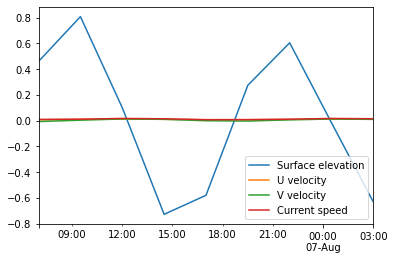

In [7]:
df.plot()

## Other ways to subset data 

Assume that we interested in these 3 points only

In [8]:
pt1 = (606200, 6905480)
pt2 = (606300, 6905410)
pt3 = (606400, 6905520)
pts_x = [pt1[0], pt2[0], pt3[0]]
pts_y = [pt1[1], pt2[1], pt3[1]]
elem_ids = dfs.find_nearest_element(pts_x, pts_y)

We can use these element ids either when we select the data from the complete dataset using the method isel() as shown above or already when we read the data from file (particular useful for files larger than memory)

In [9]:
ds_pts = dfs.read(elements=elem_ids)
ds_pts

100%|██████████| 9/9 [00:00<00:00, 2182.26it/s]


<mikeio.DataSet>
Dimensions: (9, 3)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

### Select area
Let's take the area North of y=6905480

In [10]:
yc = dfs.element_coordinates[:,1]

In [11]:
elem_ids = dfs.element_ids[yc>6905480] 

And find the maximum average current speed in this area in the last time step

In [12]:
item_num = 1
print(ds.items[item_num])
subset = ds.data[1][:,elem_ids] 
subset_timeavg = subset.mean(axis=0) 
idx = subset_timeavg.argmax()
coords = dfs.element_coordinates[idx,0:2].round(1)
print(f'Max current speed in area is found in {coords} and is {subset_timeavg[idx]:.3f}m/s')

U velocity <u velocity component> (meter per sec)
Max current speed in area is found in [ 606674.6 6905718.3] and is 0.039m/s


Let us save the time averaged subset to a dfsu file. 

In [13]:
outfilename1 = "HD2D_north.dfsu"
data = []
data.append(subset_timeavg.reshape(1,-1))
items = ds.items[item_num]
dfs.write(outfilename1, data, items=[items], elements=elem_ids)

100%|██████████| 1/1 [00:00<00:00, 249.85it/s]


# Create a new dfsu file

* Subset of items
* Subset of timesteps
* Renamed variables

First inspect the source file:

In [14]:
ds = dfs.read()
ds

100%|██████████| 9/9 [00:00<00:00, 1123.01it/s]


<mikeio.DataSet>
Dimensions: (9, 884)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

In [15]:
from mikeio.eum import ItemInfo, EUMType
from mikeio import Dataset

sourcefilename = filename
outfilename2 = "HD2D_selected.dfsu"

starttimestep = 4
time = ds.time[starttimestep:]

data = []
data.append(ds['U velocity'][starttimestep:,:])
data.append(ds['V velocity'][starttimestep:,:])

items = [ItemInfo("eastward_sea_water_velocity", EUMType.u_velocity_component),
         ItemInfo("northward_sea_water_velocity",EUMType.v_velocity_component)]

newds = Dataset(data,time,items)

dfs.write(outfilename2, newds) # Note, this method was previosly named create

100%|██████████| 5/5 [00:00<00:00, 1665.99it/s]


Read the newly created file to verify the contents.

In [16]:
newdfs = Dfsu(outfilename2)

newds2 = newdfs.read()
newds2

100%|██████████| 5/5 [00:00<00:00, 4995.60it/s]


<mikeio.DataSet>
Dimensions: (5, 884)
Time: 1985-08-06 17:00:00 - 1985-08-07 03:00:00
Items:
  0:  eastward_sea_water_velocity <u velocity component> (meter per sec)
  1:  northward_sea_water_velocity <v velocity component> (meter per sec)

# Write mesh from dfsu file
Don't you have the original mesh? No problem - you can re-create it from the dfsu file... 

In [17]:
outmesh = 'mesh_from_HD2D.mesh'
dfs.to_mesh(outmesh)

# Clean up

In [18]:
import os
os.remove(outfilename1)
os.remove(outfilename2)
os.remove(outmesh)